In [1]:
import pandas as pd
import json
import numpy as np
import random
from nltk.tokenize import WhitespaceTokenizer
from tqdm import tqdm
random.seed()

In [2]:
def generate_dataset(data: dict):
    samples = []
    note_question_id = 0
    error_counter = 0
    for paragraph in tqdm(data['paragraphs']):
        context = paragraph['context']
        note_id = paragraph['note_id']
        qas = paragraph['qas']
        for qa in qas:
            for answer, _, question in zip(qa['answers'], qa['id'], qa['question']):
                if answer['answer_entity_type'] in {'single', 'empty'}:
                    evidence_start = answer['evidence_start'] - 2
                    evidence = answer['evidence']
                    sample = generate_sample(note_id, note_question_id, context, question.split(), evidence_start, evidence.split())
                    if sample == []:
                        error_counter += 1
                    else:
                        samples.extend(sample)
                
                elif answer['answer_entity_type'] == 'complex':
                    # TODO: Figure this out
                    pass

                # Additional Check
                else:
                    print(f'Unknown Operation for id: {id}')
                note_question_id += 1 
    samples = pd.DataFrame(samples, columns=['note_id', 'note_question_id', 'sub_context', 
                                             'question', 'answerability', 
                                             'token_start', 'token_end', 
                                             'char_start', 'char_end'
                                            ])
    print('error counter:', error_counter)
    return samples

def generate_sample(note_id: int, note_question_id: int, context: list, question: list, evidence_start: int, evidence: list):
    
    samples = []

    token_counts = []
    prev_i = 0
    
    sub_context = []
    for i, line in enumerate(context):
        
        line_tokens = line.split()
        
        if len(sub_context) > 200 or i+1 == len(context):
            # Positive Example
            if prev_i <= evidence_start < i-1:
                answerability = 1
                
                # Token Position
                token_cumsum = np.cumsum(token_counts)
                evidence_token_start = token_cumsum[evidence_start-prev_i]
                evidence_token_end = evidence_token_start + len(evidence)
                token_match_cond = sub_context[evidence_token_start: evidence_token_end] == evidence
                
                # Charactor Position
                sub_context_str = ' '.join(sub_context)
                evidence_char_start = len(' '.join(sub_context[:evidence_token_start])) + 1
                evidence_char_end = evidence_char_start + len(' '.join(evidence))
                char_match_cond = sub_context_str[evidence_char_start: evidence_char_end] == ' '.join(evidence)
                
                # Checking Condition
                if token_match_cond and char_match_cond:
                    positive_sample = [note_id, note_question_id, sub_context, question, answerability, 
                                       evidence_token_start, evidence_token_end,
                                       evidence_char_start, evidence_char_end]
                    samples.append(positive_sample)
                    
                else:
                    # Two line evidence on the border.
#                     print("Error")
#                     print(sub_context)
#                     print(len(sub_context))
#                     print(evidence_token_start, evidence_token_end)
#                     print(sub_context[evidence_token_start: evidence_token_end], evidence)
                    return []
                    
            # Negative Example
            else:
                answerability = 0
                evidence_token_start = 0
                evidence_token_end = 0
                evidence_char_start = 0
                evidence_char_end = 0
                
                negative_sample = [note_id, note_question_id, sub_context, question, answerability,
                                    evidence_token_start, evidence_token_end,
                                    evidence_char_start, evidence_char_end]
                samples.append(negative_sample)
            
            sub_context = line_tokens
            token_counts = [len(line_tokens)]
            prev_i = i
            
        else:
            sub_context += line_tokens
            token_counts.append(len(line_tokens))
       
    return samples 

In [13]:
with open('n2c2-community-annotations_2014-pampari-question-answering/dataset/medication-qa.json') as f:
    data = json.load(f)

samples = generate_dataset(data)

100%|██████████| 262/262 [00:16<00:00, 15.80it/s]


error counter: 169


In [14]:
samples.head()

,note_id,note_question_id,sub_context,question,answerability,token_start,token_end,char_start,char_end
0,91996,0,"[RECORD, #91996, 150823816, |, DMC, |, 6095698...","[Was, the, patient, ever, prescribed, aspirin]",1,94,106,548,613
1,91996,0,"[documented, recent, seizures;, history, of, a...","[Was, the, patient, ever, prescribed, aspirin]",0,0,0,0,0
2,91996,0,"[of, chronic, headaches, for, which, she, was,...","[Was, the, patient, ever, prescribed, aspirin]",0,0,0,0,0
3,91996,0,"[and, repeat, PET, labs., As, well, ,, she, ha...","[Was, the, patient, ever, prescribed, aspirin]",0,0,0,0,0
4,91996,0,"[feeling, that, these, were, not, true, seizur...","[Was, the, patient, ever, prescribed, aspirin]",0,0,0,0,0


In [15]:
samples.answerability.value_counts()

0    191200
1     30240
Name: answerability, dtype: int64

In [16]:
positive_samples = samples[samples.answerability==1]

<AxesSubplot:>

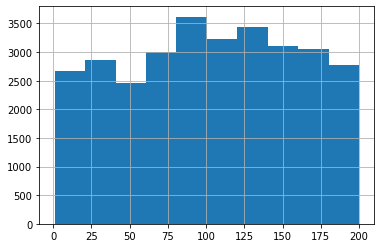

In [17]:
positive_samples.token_start.hist()

<AxesSubplot:>

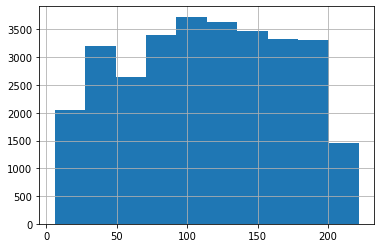

In [18]:
positive_samples.token_end.hist()

In [19]:
samples.to_parquet('processed_data/medication_qa.parquet')

In [3]:
with open('n2c2-community-annotations_2014-pampari-question-answering/dataset/relations-qa.json') as f:
    data = json.load(f)

samples = generate_dataset(data)

100%|██████████| 426/426 [00:15<00:00, 28.18it/s]


error counter: 0


In [4]:
samples.to_parquet('processed_data/relations_qa.parquet')